In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [ ]:
seed = 1337
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:
IMAGES_PATH = "Flicker8k_Dataset"
IMAGE_SIZE = (299, 299)

VOCAB_SIZE = 10000
SEQ_LENGTH = 25
EMBED_DIM = 512
FEED_FORWARD_DIM = 512

BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
def load_captions_data(filename):
  '''
    Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
  '''

  with open(filename) as caption_file:
    # Return all lines in the file, as a list where each line is an item in the list
    caption_data = caption_file.readlines()
    caption_mapping = {}
    text_data = []
    images_to_skip = set()

    for line in caption_data:
      # Returns every line in caption_data separately
      line = line.rstrip('\n')
      # Image name and captions are separated using a tab
      img_name, caption = line.split('\t')
      # Strip method removes the spaces at the beggining or the end of the string
      # Each image is repeated five times for the five different captions.
      # Each image name has a suffix `#(caption_number)'
      img_name = img_name.split('#')[0]
      img_name = os.path.join(IMAGES_PATH, img_name.strip())

      # We will remove caption that are either too short to too long
      tokens = caption.strip().split()

      if len(tokens)<5 or len(tokens)>SEQ_LENGTH:
        images_to_skip.add(img_name)
        continue

      if img_name.endswith('jpg') and img_name not in images_to_skip:
        # We will add a start and an end token to each caption
        caption = '<start> ' + caption.strip() +' <end>'
        text_data.append(caption)

        if img_name in caption_mapping:
          caption_mapping[img_name].append(caption)
        else:
          caption_mapping[img_name] = [caption]

    for img_name in images_to_skip:
      if img_name in caption_mapping:
        del caption_mapping[img_name]

    return caption_mapping, text_data

In [ ]:
def train_val_split(caption_data, train_size=0.8, shuffle=True):
  '''
    Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
  '''
  # Get the list of all image names
  all_images = list(caption_data.keys())

  # Shuffle if necessary
  if shuffle:
    np.random.shuffle(all_images)

  # Split into training and validation sets
  train_size = int(len(caption_data) * train_size)

  training_data = {
      img_name: caption_data[img_name] for img_name in all_images[:train_size]
  }

  validation_data = {
      img_name: caption_data[img_name] for img_name in all_images[train_size:] 
  }

  return training_data, validation_data

In [ ]:
# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [ ]:
def custom_standardization(input_string):
  lowercase = tf.strings.lower(input_string)

  return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization
)

vectorization.adapt(text_data)

In [ ]:
image_augmentation = keras.Sequential([
                          keras.layers.RandomFlip('horizontal'),
                          keras.layers.RandomRotation(0.2),
                          keras.layers.RandomContrast(0.3)
])

In [ ]:
def decode_and_resize(img_path, size=IMAGE_SIZE):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SIZE)

  return img

In [ ]:
def read_train_image(img_path, size=IMAGE_SIZE):
  img = decode_and_resize(img_path)
  img = image_augmentation(tf.expand_dims(img, 0))[0]
  img = tf.image.convert_image_dtype(img, tf.float32)

  return img

In [ ]:
def read_valid_image(img_path, size=IMAGE_SIZE):
  img = decode_and_resize(img_path)
  img = tf.image.convert_image_dtype(img, tf.float32)

  return img

In [ ]:
def make_dataset(images, captions, split='train'):
  if split == 'train':
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(read_train_image, num_parallel_calls=AUTOTUNE)
  else:
    img_dataset = tf.data.Dataset.from_tensor_slices(images).map(read_valid_image, num_parallel_calls=AUTOTUNE)

  cap_dataset = tf.data.Dataset.from_tensor_slices(captions).map(vectorization, num_parallel_calls=AUTOTUNE)

  dataset = tf.data.Dataset.zip((img_dataset, cap_dataset))
  dataset = dataset.batch(BATCH_SIZE).shuffle(256).prefetch(AUTOTUNE)

  return dataset

In [ ]:
train_dataset = make_dataset(
    list(train_data.keys()),
    list(train_data.values()),
    split='train'
)

valid_dataset = make_dataset(
    list(valid_data.keys()),
    list(valid_data.values()),
    split='valid'
)

In [ ]:
def get_cnn_backbone():
  base_model = keras.applications.efficientnet.EfficientNetB0(
      input_shape=(*IMAGE_SIZE, 3),
      include_top=False,
      weights='imagenet'
  )

  base_model.trainable = False
  base_model_out = base_model.output
  base_model_out = keras.layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
  cnn_model = keras.models.Model(base_model.input,
                                 base_model_out)
  
  return cnn_model

In [ ]:
class TransformerEncoderBlock(keras.layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__()
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads

    self.attention1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                      key_dim=embed_dim,
                                                      dropout=0.0)
    self.layernorm_1 = keras.layers.LayerNormalization()
    self.layernorm_2 = keras.layers.LayerNormalization()
    self.dense_1 = keras.layers.Dense(embed_dim, 
                                      activation=tf.nn.gelu)
    
  def call(self, inputs, training, mask=None):
    inputs = self.layernorm_1(inputs)
    inputs = self.dense_1(inputs)

    attention_output_1 = self.attention1(query=inputs,
                                         value=inputs,
                                         key=inputs,
                                         attention_mask=None,
                                         training=training)
    
    out_1 = self.layernorm_2(inputs + attention_output_1)

    return out_1

In [ ]:
class PositionalEmbedding(keras.layers.Layer):
  def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
    super().__init__()

    self.token_embeddings = keras.layers.Embedding(input_dim=vocab_size,
                                                   output_dim=embed_dim)
    self.position_embeddings = keras.layers.Embedding(input_dim=sequence_length,
                                                     output_dim=embed_dim)
    self.sequence_length = sequence_length
    self.vocab_size = vocab_size
    self.embed_dim = embed_dim
    self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

  def call(self,inputs):
    length = tf.shape(inputs)[-1]
    positions = tf.range(start=0, limit=length, delta=1)
    embedded_tokens = self.token_embeddings(inputs)
    embedded_tokens = embedded_tokens * self.embed_scale
    embedded_positions = self.position_embeddings(positions)

    return embedded_tokens + embedded_positions

  def compute_mask(self, inputs, mask=None):
    return tf.math.not_equal(inputs, 0)

In [ ]:
class TransformerDecoderBlock(keras.layers.Layer):
  def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
    super().__init__()

    self.embed_dim = embed_dim
    self.feed_forward_dim = ff_dim
    self.num_heads = num_heads

    self.attention_1 = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                       key_dim=embed_dim,
                                                       dropout=0.1)
    
    self.attention_2 = keras.layers.MultiHeadAttention(num_heads=num_heads,
                                                       key_dim=embed_dim,
                                                       dropout=0.1)
    
    self.ffn_layer1 = keras.layers.Dense(ff_dim,
                                         activation=tf.nn.gelu)
    self.ffn_layer2 = keras.layers.Dense(embed_dim)

    self.layer_norm1 = keras.layers.LayerNormalization()
    self.layer_norm2 = keras.layers.LayerNormalization()
    self.layer_norm3 = keras.layers.LayerNormalization()

    self.embedding = PositionalEmbedding(embed_dim=EMBED_DIM,
                                         sequence_length=SEQ_LENGTH,
                                         vocab_size=VOCAB_SIZE)
    self.out = keras.layers.Dense(VOCAB_SIZE, 
                                  activation='softmax')
    
    self.dropout1 = keras.layers.Dropout(0.3)
    self.dropout2 = keras.layers.Dropout(0.5)
    self.supports_masking = True

  def call(self, inputs, encoder_outputs, training, mask=None):
    inputs = self.embedding(inputs)
    casual_mask = self.get_casual_attention_mask(inputs)
    
    if mask is not None:
      padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
      combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
      combined_mask = tf.minimum(combined_mask, casual_mask)

    attention_output_1 = self.attention_1(query=inputs,
                                          value=inputs,
                                          key=inputs,
                                          attention_mask=combined_mask,
                                          training=training)
    out_1 = self.layer_norm1(inputs + attention_output_1)

    attention_output_2 = self.attention_2(query=out_1,
                                          value=encoder_outputs,
                                          key=encoder_outputs,
                                          attention_mask=padding_mask,
                                          training=training)
    
    out_2 = self.layer_norm2(out_1 + attention_output_2)

    ffn_out = self.ffn_layer1(out_2)
    ffn_out = self.dropout1(ffn_out, training=training)
    ffn_out = self.ffn_layer2(ffn_out)

    ffn_out = self.layer_norm3(ffn_out + out_2, training=training)
    ffn_out = self.dropout2(ffn_out, training=training)
    preds = self.out(ffn_out)

    return preds

  def get_casual_attention_mask(self, inputs):
    input_shape = tf.shape(inputs)
    batch_size, sequence_length = input_shape[0], input_shape[1]
    i = tf.range(sequence_length)[:, tf.newaxis]
    j = tf.range(sequence_length)
    mask = tf.cast(i>=j, dtype=tf.int32)
    mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
    mult = tf.concat(
        [tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype=tf.int32)],
        axis=0
    )

    return tf.tile(mask, mult)

In [ ]:
class ImageCaptioningModel(keras.Model):
  def __init__(self, cnn_model, encoder, decoder, num_captions_per_image=5):
    super().__init__()

    self.cnn_model = cnn_model
    self.encoder = encoder
    self.decoder = decoder
    self.loss_tracker = keras.metrics.Mean(name='loss')
    self.acc_tracker = keras.metrics.Mean(name='accuracy')
    self.num_captions_per_image = num_captions_per_image

  def calculate_loss(self, y_true, y_pred, mask):
    loss = self.loss(y_true, y_pred)
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

  def calculate_accuracy(self, y_true, y_pred, mask):
    accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
    accuracy = tf.math.logical_and(mask, accuracy)
    accuracy = tf.cast(accuracy, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)

    return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

  def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
    encoder_out = self.encoder(img_embed, training=training)
    batch_seq_inp = batch_seq[:, :-1]
    batch_seq_true = batch_seq[:, 1:]
    mask = tf.math.not_equal(batch_seq_true, 0)
    batch_seq_pred = self.decoder(batch_seq_inp, 
                                  encoder_out, 
                                  training=training,
                                  mask=mask)
    loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
    acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)

    return loss, acc

  def train_step(self, batch_data):
    batch_img, batch_seq = batch_data
    batch_loss = 0
    batch_acc = 0

    # 1. Get image embeddings
    img_embed = self.cnn_model(batch_img)

    # 2. Pass each of the five captions one by one to the decoder
    # along with the encoder outputs and compute the loss as well as accuracy
    # for each caption.

    for i in range(self.num_captions_per_image):
      with tf.GradientTape() as tape:
        loss, acc = self._compute_caption_loss_and_acc(img_embed,
                                                       batch_seq[:, i, :],
                                                       training=True)
      
        
        # 3. Update loss and accuracy
        batch_loss += loss
        batch_acc += acc

      # 4. Get the list of all the trainable weights
      train_vars = (self.encoder.trainable_variables + self.decoder.trainable_variables)

      # 5. Get the gradients
      grads = tape.gradient(loss, train_vars)

      # 6. Update the trainable weights
      self.optimizer.apply_gradients(zip(grads, train_vars))
    # 7. Update the trackers

    batch_acc /= float(self.num_captions_per_image)
    self.loss_tracker.update_state(batch_loss)
    self.acc_tracker.update_state(batch_acc)

    # 8. Return the loss and accuracy values
    return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

  def test_step(self, batch_data):
    batch_img, batch_seq = batch_data
    batch_loss = 0
    batch_acc = 0

    img_embed = self.cnn_model(batch_img)

    for i in range(self.num_captions_per_image):
      loss, acc = self._compute_caption_loss_and_acc(
          img_embed,
          batch_seq[:, i, :],
          training=False
      )

      batch_loss += loss
      batch_acc += acc

    batch_acc /= float(self.num_captions_per_image)
    self.loss_tracker.update_state(batch_loss)
    self.acc_tracker.update_state(batch_acc)

    return {"loss": self.loss_tracker.result(), "acc": self.acc_tracker.result()}

  @property
  def metrics(self):
    # We need to list our metrics here so the `reset_states()` can be
    # called automatically.

    return [self.loss_tracker, self.acc_tracker]

In [ ]:
cnn_model = get_cnn_backbone()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FEED_FORWARD_DIM, num_heads=4)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FEED_FORWARD_DIM, num_heads=5)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model, encoder=encoder, decoder=decoder
)

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
cross_entropy = keras.losses.SparseCategoricalCrossentropy(from_logits=False,
                                                           reduction='none')

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(patience=3,
                                               restore_best_weights=True)

In [ ]:
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, post_warmup_learning_rate, warmup_steps):
    super().__init__()

    self.post_warmup_learning_rate = post_warmup_learning_rate
    self.warmup_steps = warmup_steps

  def __call__(self, step):
    global_step = tf.cast(step, tf.float32)
    warmup_steps = tf.cast(self.warmup_steps, tf.float32)
    warmup_progress = global_step / warmup_steps
    warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress

    return tf.cond(global_step < warmup_steps,
                   lambda: warmup_learning_rate,
                   lambda: self.post_warmup_learning_rate)

In [ ]:
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4,
                         warmup_steps=num_warmup_steps)

In [ ]:
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule),
                      loss=cross_entropy)

In [ ]:
caption_model.load_weights('image_caption.h5')

In [ ]:
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

In [ ]:
caption_model.evaluate(valid_dataset)

24/24 [==============================] - 469s 19s/step - loss: 46.4021 - acc: 7.3483e-05


[46.40214920043945, 5.564766252064146e-05]

In [ ]:
caption_model.load_weights('caption_model_tf')

In [ ]:
caption_model.evaluate(valid_dataset)

24/24 [==============================] - 461s 19s/step - loss: 14.8062 - acc: 0.4205


[14.80621337890625, 0.4207804203033447]

In [ ]:
vocab = vectorization.get_vocabulary()
index_lookup = dict(zip(range(len(vocab)), vocab))
max_decoded_sentence_length = SEQ_LENGTH - 1
valid_images = list(valid_data.keys())

In [ ]:
def generate_caption():
  
  sample_img = np.random.choice(valid_images)

  sample_img = read_valid_image(sample_img)
  img = sample_img.numpy().clip(0, 255).astype(np.uint8)

  plt.imshow(img)
  plt.show()

  img = tf.expand_dims(sample_img, 0)
  img = caption_model.cnn_model(img)

  encoded_img = caption_model.encoder(img, training=False)

  decoded_caption = '<start> '

  for i in range(max_decoded_sentence_length):
    tokenized_caption = vectorization([decoded_caption])[:, :-1]
    mask = tf.math.not_equal(tokenized_caption, 0)
    predictions = caption_model.decoder(tokenized_caption,
                                        encoded_img,
                                        training=False,
                                        mask=mask)
    sample_token_index = np.argmax(predictions[0, i, :])
    sampled_token = index_lookup[sample_token_index]

    if sampled_token == ' <end>':
      break
    decoded_caption += ' ' + sampled_token

  decoded_caption = decoded_caption.replace('<start> ', "")
  decoded_caption = decoded_caption.replace(" <end>", "").strip()
  decoded_caption = decoded_caption.capitalize()
  print(f'Predicted caption -> {decoded_caption}')

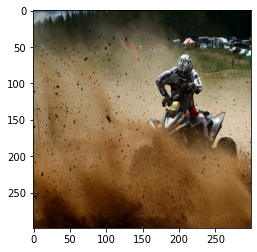

Predicted caption -> A man is riding a dirt bike in the air in the middle of a race


In [ ]:
generate_caption()

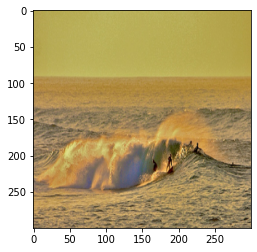

Predicted caption -> A person is surfing on a large wave in the ocean


In [ ]:
generate_caption()

In [ ]:
def generate_caption_for_img(path):

  sample_img = read_valid_image(path)
  img = sample_img.numpy().clip(0, 255).astype(np.uint8)

  plt.imshow(img)
  plt.show()

  img = tf.expand_dims(sample_img, 0)
  img = caption_model.cnn_model(img)

  encoded_img = caption_model.encoder(img, training=False)

  decoded_caption = '<start> '

  for i in range(max_decoded_sentence_length):
    tokenized_caption = vectorization([decoded_caption])[:, :-1]
    mask = tf.math.not_equal(tokenized_caption, 0)
    predictions = caption_model.decoder(tokenized_caption,
                                        encoded_img,
                                        training=False,
                                        mask=mask)
    sample_token_index = np.argmax(predictions[0, i, :])
    sampled_token = index_lookup[sample_token_index]

    if sampled_token == ' <end>':
      break
    decoded_catpion += ' ' + sampled_token

  decoded_caption = decoded_caption.replace('<start> ', "")
  decoded_caption = decoded_caption.replace(" <end>", "").strip()
  decoded_caption = decoded_caption.capitalize()
  print(f'Predicted caption -> {decoded_caption}')

In [ ]:
generate_caption_for_img('dog.jpg')